# **MolecularForecast challenge**
*A guide for starting the challenge*

In [72]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing, svm 
from sklearn.preprocessing import MinMaxScaler 
from sklearn.model_selection import train_test_split 
from sklearn.linear_model import LinearRegression 
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
import xgboost as xgb
from xgboost import XGBClassifier
from itertools import islice
import pickle


In [73]:
kinases = pd.read_excel('Table-1.xlsx')
kinases.head(8)

,Accession Number,Entrez Gene Symbol,Kinase,Mutant,Kinase Group
0,NP_055726.3,AAK1,AAK1,NO,Other
1,NP_005148.2,ABL1,ABL1(E255K)-phosphorylated,YES,TK
2,NP_005148.2,ABL1,ABL1(F317I)-nonphosphorylated,YES,TK
3,NP_005148.2,ABL1,ABL1(F317I)-phosphorylated,YES,TK
4,NP_005148.2,ABL1,ABL1(F317L)-nonphosphorylated,YES,TK
5,NP_005148.2,ABL1,ABL1(F317L)-phosphorylated,YES,TK
6,NP_005148.2,ABL1,ABL1(H396P)-nonphosphorylated,YES,TK
7,NP_005148.2,ABL1,ABL1(H396P)-phosphorylated,YES,TK


In [74]:
# Retrieve amino acid sequences from pickle file

with open("all_seqs.pkl", "rb") as f:
    uniprot = pickle.load(f)
dict(islice(uniprot.items(), 8))


{'AAK1': 'MKKFFDSRREQGGSGLGSGSSGGGGSTSGLGSGYIGRVFGIGRQQVTVDEVLAEGGFAIVFLVRTSNGMKCALKRMFVNNEHDLQVCKREIQIMRDLSGHKNIVGYIDSSINNVSSGDVWEVLILMDFCRGGQVVNLMNQRLQTGFTENEVLQIFCDTCEAVARLHQCKTPIIHRDLKVENILLHDRGHYVLCDFGSATNKFQNPQTEGVNAVEDEIKKYTTLSYRAPEMVNLYSGKIITTKADIWALGCLLYKLCYFTLPFGESQVAICDGNFTIPDNSRYSQDMHCLIRYMLEPDPDKRPDIYQVSYFSFKLLKKECPIPNVQNSPIPAKLPEPVKASEAAAKKTQPKARLTDPIPTTETSIAPRQRPKAGQTQPNPGILPIQPALTPRKRATVQPPPQAAGSSNQPGLLASVPQPKPQAPPSQPLPQTQAKQPQAPPTPQQTPSTQAQGLPAQAQATPQHQQQLFLKQQQQQQQPPPAQQQPAGTFYQQQQAQTQQFQAVHPATQQPAIAQFPVVSQGGSQQQLMQNFYQQQQQQQQQQQQQQLATALHQQQLMTQQAALQQKPTMAAGQQPQPQPAAAPQPAPAQEPAIQAPVRQQPKVQTTPPPAVQGQKVGSLTPPSSPKTQRAGHRRILSDVTHSAVFGVPASKSTQLLQAAAAEASLNKSKSATTTPSGSPRTSQQNVYNPSEGSTWNPFDDDNFSKLTAEELLNKDFAKLGEGKHPEKLGGSAESLIPGFQSTQGDAFATTSFSAGTAEKRKGGQTVDSGLPLLSVSDPFIPLQVPDAPEKLIEGLKSPDTSLLLPDLLPMTDPFGSTSDAVIEKADVAVESLIPGLEPPVPQRLPSQTESVTSNRTDSLTGEDSLLDCSLLSNPTTDLLEEFAPTAISAPVHKAAEDSNLISGFDVPEGSDKVAEDEFDPIPVLITKNPQGGHSRNSSGSSESSLPNLARSLLLVDQLIDL',
 'ABL1(E255K)-phosphorylat

# Opening the dissociation constant dataframe


In [75]:
Kd = pd.read_excel('Table-3_train.xlsx')
Kd.head(8)

,Accession Number,Entrez Gene Symbol,Kinase,A-674563,AB-1010,ABT-869,AC220,AG-013736,AST-487,AT-7519,...,PP-242,PTK-787,R406,R547,SB-203580,SGX-523,Staurosporine,TAE-684,TG-101348,Vandetanib
0,NP_055726.3,AAK1,AAK1,43.0,10001.0,10001.0,10001.0,1200.0,10001.00,10001.0,...,1600.0,10001.0,410.0,10001.0,10001,10001.0,1.2,470.0,35.0,10001.0
1,NP_005148.2,ABL1,ABL1(E255K)-phosphorylated,10001.0,140.0,10001.0,10001.0,63.0,75.00,10001.0,...,56.0,10001.0,220.0,10001.0,10001,10001.0,22.0,190.0,40.0,13.0
2,NP_005148.2,ABL1,ABL1(F317I)-nonphosphorylated,10001.0,8.0,10001.0,10001.0,2600.0,1.90,10001.0,...,10001.0,10001.0,10001.0,10001.0,10001,10001.0,550.0,93.0,2100.0,770.0
3,NP_005148.2,ABL1,ABL1(F317I)-phosphorylated,10001.0,78.0,10001.0,10001.0,800.0,13.00,10001.0,...,1200.0,10001.0,10001.0,10001.0,10001,10001.0,130.0,14.0,560.0,170.0
4,NP_005148.2,ABL1,ABL1(F317L)-nonphosphorylated,10001.0,10.0,10001.0,10001.0,830.0,0.77,10001.0,...,10001.0,10001.0,10001.0,10001.0,10001,10001.0,170.0,54.0,450.0,75.0
5,NP_005148.2,ABL1,ABL1(F317L)-phosphorylated,10001.0,110.0,10001.0,10001.0,330.0,13.00,10001.0,...,240.0,10001.0,10001.0,10001.0,10001,10001.0,46.0,19.0,180.0,33.0
6,NP_005148.2,ABL1,ABL1(H396P)-nonphosphorylated,10001.0,11.0,10001.0,10001.0,20.0,2.60,10001.0,...,49.0,10001.0,170.0,10001.0,2600,3400.0,18.0,73.0,45.0,9.8
7,NP_005148.2,ABL1,ABL1(H396P)-phosphorylated,10001.0,140.0,10001.0,10001.0,23.0,31.00,10001.0,...,58.0,10001.0,390.0,10001.0,3900,10001.0,36.0,160.0,61.0,14.0


In [76]:
sensitivities = pd.read_csv('Table-2_train.csv')
sensitivities.head(8)

,Compound,SMILES,Binding Mode (based on ABL1-phos. vs. -nonphos affinity),S(300nM),S(3000nM)
0,A-674563,CC1=C2C=C(C=CC2=NN1)C3=CC(=CN=C3)OCC(CC4=CC=CC...,undetermined,0.1166,0.2772
1,AB-1010,CC1=C(C=C(C=C1)NC(=O)C2=CC=C(C=C2)CN3CCN(CC3)C...,Type II,0.0337,0.0622
2,ABT-869,CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=C...,undetermined,0.0648,0.1839
3,AC220,CC(C)(C)C1=CC(=NO1)NC(=O)NC2=CC=C(C=C2)C3=CN4C...,Type II,0.0285,0.0751
4,AG-013736,CNC(=O)C1=CC=CC=C1SC2=CC3=C(C=C2)C(=NN3)C=CC4=...,Type I,0.0570,0.1969
5,AST-487,CCN1CCN(CC1)CC2=C(C=C(C=C2)NC(=O)NC3=CC=C(C=C3...,Type II,0.2617,0.4922
6,AT-7519,C1CNCCC1NC(=O)C2=C(C=NN2)NC(=O)C3=C(C=CC=C3Cl)Cl,undetermined,0.0674,0.0933
7,AZD-1152HQPA,CCN(CCCOC1=CC2=C(C=C1)C(=NC=N2)NC3=NNC(=C3)CC(...,Type II,0.0311,0.1140


In [77]:
# returns a dataframe with each inhibitor OR kinase and the corresponding generated feature
def makeFeature(sourcedf, fxns:dict, type:{"inhibitor", "kinase"}):
    ''' fxns is a dictionary where:
        keys: column name, of the target column in sourcedf
        values: function, to apply to the target column in sourcedf and generate a feature
                each feature value is then normalized
    '''
    featuredf = pd.DataFrame()
    for col,fxn in fxns.items():
        if type == "inhibitor":
            featuredf['Compound'] = sourcedf['Compound']
        else:
            featuredf['Kinase'] = sourcedf['Kinase']
        featuredf[col+" embedded"] = sourcedf[col].apply(fxn)
        featuredf[col+" embedded"] = MinMaxScaler().fit_transform(np.array(featuredf[col+" embedded"]).reshape(-1,1)) 
    return featuredf

# returns an dataframe with both the inhibitor and kinase features for each possible inhibitor-kinase pair
def createX(inhibitordf, kinasedf):
    result = pd.merge(inhibitordf, kinasedf, how='cross')
    return result

# returns a dataframe with the Kd for each possible inhibitor-kinase pair
def createY(sourcedf, Sthresh):
    Kdf = sourcedf.drop(['Accession Number', 'Entrez Gene Symbol'], axis=1)
    Kdf = Kdf.set_index('Kinase')
    stacked = Kdf.stack().reset_index()
    stacked.columns = ['Kinase', 'Compound', 'Kd']
 
    stacked[f'Kd'] = (stacked['Kd'] < Sthresh).astype(int)
    return stacked.set_index(['Compound', 'Kinase'])





In [78]:
# these are the feature dataframes used by the model
Y1 = createY(Kd, 300)
Y10 = createY(Kd, 3000)


In [79]:
# Initial X and Y datasets, where the only features are the specificity
inhibitorFeatures = makeFeature(sensitivities, {"S(300nM)":(lambda a: a), 
                                                "S(3000nM)":(lambda a: a)}, "inhibitor")
kinaseFeatures = pd.DataFrame()
kinaseFeatures['Kinase'] = list(uniprot.keys())

# the merged features dataset with all the inhibitor and kinase pairs 
X = kinaseFeatures.merge(inhibitorFeatures, how='cross')
X = X.set_index(['Compound', 'Kinase'])

def XGBtrain(X, Y, title):
    data = X.merge(Y, on=['Compound', 'Kinase'], how='inner')
    x = data.iloc[:,:-1].values
    y = data.iloc[:,-1].values

    X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.20, random_state=33)

    # X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42) # 0.25 x 0.8 = 0.2
    # the above is not needed because there are 12 inhibitors that will be released 
    # for the challenge at 11:00 am on 3/16/2025

    model = XGBClassifier()
    model.fit(X_train, y_train)
    y_train = np.array(y_train).ravel()
    y_pred = model.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred) * 100
    precision = precision_score(y_test, y_pred) * 100
    recall = recall_score(y_test, y_pred) * 100
    ratio = (Y['Kd'] == 1).sum()/len(Y)
    print(f"Ratio of Kd < threshold to Kd > threshold: {ratio}")
    print(f"Results from the {title}\naccuracy: {accuracy}\nprecision: {precision}")
    print(f"recall: {recall}\n")
    metrics = [accuracy, precision, recall, ratio]

    return X_test, y_pred, model, metrics

X1_result, y1_result, XGB300, metrics1 = XGBtrain(X, Y1, "XGB model with a Kd threshold of 300")
X10_result, y10_result, XGB3000, metrics10 = XGBtrain(X, Y10, "XGB model with a Kd threshold of 3000")

Ratio of Kd < threshold to Kd > threshold: 0.1144419306184012
Results from the XGB model with a Kd threshold of 300
accuracy: 90.2542372881356
precision: 59.61538461538461
recall: 17.350746268656717

Ratio of Kd < threshold to Kd > threshold: 0.2382730015082956
Results from the XGB model with a Kd threshold of 3000
accuracy: 81.29815100154083
precision: 63.48623853211009
recall: 30.94812164579606



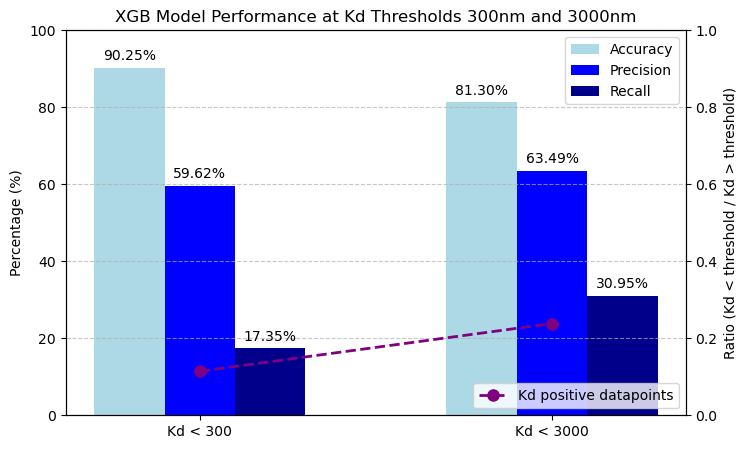

In [80]:
data = {
    "Kd < 300": metrics1,
    "Kd < 3000": metrics10,
}

def plot_results(data) :# Extracting values for plotting
    thresholds = list(data.keys())
    accuracy = [data[t][0] for t in thresholds]
    precision = [data[t][1] for t in thresholds]
    recall = [data[t][2] for t in thresholds]
    ratios = [data[t][3] for t in thresholds]

    fig, ax1 = plt.subplots(figsize=(8, 5))
    x = np.arange(len(thresholds))
    width = 0.2  

    ax1.bar(x - width, accuracy, width, label="Accuracy", color='lightblue')
    ax1.bar(x, precision, width, label="Precision", color='blue')
    ax1.bar(x + width, recall, width, label="Recall", color='darkblue')

    ax1.set_ylabel("Percentage (%)")
    ax1.set_title("XGB Model Performance at Kd Thresholds 300nm and 3000nm")
    ax1.set_xticks(x)
    ax1.set_xticklabels(thresholds)
    ax1.set_ylim(0, 100)
    ax1.legend()
    ax1.grid(axis="y", linestyle="--", alpha=0.7)

    for i in range(len(thresholds)):
        ax1.text(x[i] - width, accuracy[i] + 2, f"{accuracy[i]:.2f}%", ha='center', fontsize=10)
        ax1.text(x[i], precision[i] + 2, f"{precision[i]:.2f}%", ha='center', fontsize=10)
        ax1.text(x[i] + width, recall[i] + 2, f"{recall[i]:.2f}%", ha='center', fontsize=10)

    ax2 = ax1.twinx()
    ax2.plot(thresholds, ratios, color='purple', marker='o', linestyle='dashed', linewidth=2, markersize=8, label="Kd positive datapoints")
    ax2.set_ylabel("Ratio (Kd < threshold / Kd > threshold)")
    ax2.set_ylim(0, 1)
    ax2.legend(loc="lower right")

    plt.show()

plot_results(data)

In [81]:
# function to calculate selectivity score 
def selectivity(df, col, threshold):
    filtered_col = df[col][df[col] < threshold]

    sum = filtered_col.sum()
    count = filtered_col.count()  

    return sum/count

# example on the original Kd dataset given
selectivity(Kd, 'AB-1010', 3000)

464.73111111111115

In [82]:
Kd_test = pd.read_excel('Table-3_test.xlsx')
sensitivities_test = pd.read_csv('Table-2_test.csv')

inhibitorFeatures = makeFeature(sensitivities_test, {"S(300nM)":(lambda a: a), 
                                                "S(3000nM)":(lambda a: a)}, "inhibitor")

kinaseFeatures = pd.DataFrame()
kinaseFeatures['Kinase'] = list(uniprot.keys())

X_test = kinaseFeatures.merge(inhibitorFeatures, how='cross')
X_test = X_test.set_index(['Compound', 'Kinase'])
y_pred_test = XGB300.predict(X_test)
y_pred_test2 = XGB3000.predict(X_test)

Y1_test = createY(Kd_test, 300)
Y2_test = createY(Kd_test, 3000)

accuracy1 = accuracy_score(y_pred_test, Y1_test) *100
precision1 = precision_score(y_pred_test, Y1_test) * 100
recall1 = recall_score(y_pred_test, Y1_test) * 100
ratio1 = (Y1_test['Kd'] == 1).sum()/len(Y1_test)



accuracy2 = accuracy_score(y_pred_test2, Y2_test) * 100
precision2 = precision_score(y_pred_test2, Y2_test) * 100
recall2 = recall_score(y_pred_test2, Y2_test) * 100
ratio2 = (Y2_test['Kd'] == 1).sum()/len(Y1_test)

data2 = {
    "Kd < 300": [accuracy1, precision1, recall1, ratio1],
    "Kd < 3000": [accuracy2, precision2, recall2, ratio2],
}



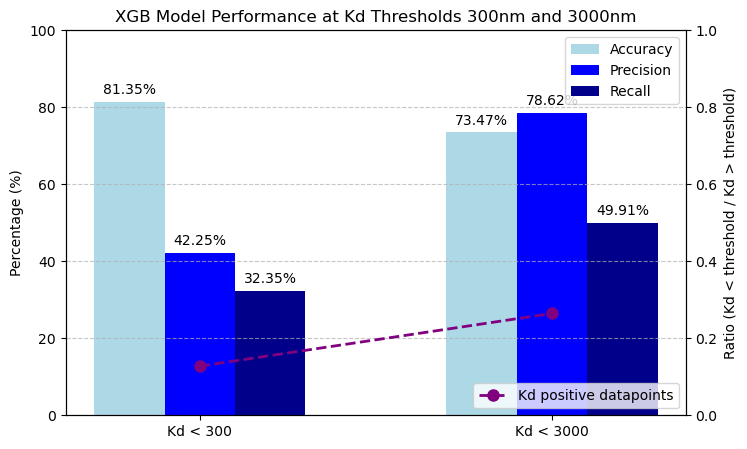

In [83]:
plot_results(data2)